In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, get_sun, get_body
from astropy.time import Time
from astropy.visualization import quantity_support
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from datetime import datetime
import warnings
from astral import moon
warnings.filterwarnings("ignore")
quantity_support()
year = 2026
wanaka_long = 169.2455
# wanaka_long = 19.2455


def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : `~astropy.units.Quantity`
        Phase angle of the moon [radians]
    """
    sun = get_sun(time)
    moon = get_body("moon", time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance * np.sin(elongation),
                      moon.distance - sun.distance * np.cos(elongation))

def get_moons_in_year(year: int) :
  """Returns a list of the full and new moons in a year. The list contains tuples
of either the form (DATE,'full') or the form (DATE,'new')"""
  moons=[]
  date=ephem.Date(datetime.date(year,1,1))
  while date.datetime().year==year:
    date=ephem.next_full_moon(date)
    moons.append( (date,'full') )
  date=ephem.Date(datetime.date(year,1,1))
  while date.datetime().year==year:
    date=ephem.next_new_moon(date)
    moons.append( (date,'new') )
  #Note that previous_first_quarter_moon() and previous_last_quarter_moon()
  #are also methods
  moons.sort(key=lambda x: x[0])

  return moons

# Widgets : sliders latitude, longitude
lat_slider = widgets.FloatSlider(
    value=-41.3,
    min=-65.0,
    max=-20.0,
    step=0.1,
    description='Latitude [°S]',
    continuous_update=True
)

lon_slider = widgets.FloatSlider(
    value=wanaka_long,
    min=-180.0,
    max=180.0,
    step=1.0,
    description='Longitude [°]',
    continuous_update=True
)



# Widget cible céleste (Combobox RA/DEC)
target_box = widgets.SelectMultiple(
    options=[
        "COSMOS: α=150, δ=2",
        "DEEP2-3: α=352, δ=0",
        "ELAIS N1: α=243, δ=55",
        "XMM-LSS: α=36, δ=2-5",
        "Optimized: α=150, δ=-80",
        "Crab Nebula:α=83.63, δ=22.01", 
        "Test: α=210, δ=-60"
    ],
    value=["COSMOS: α=150, δ=2"],
    description='Targets :',
    layout={'width': '400px', 'height': '100px'}
)

def parse_coordinates(text):
    try:
        # Extraction des valeurs numériques depuis la chaîne de type "COSMOS: α=150, δ=2"
        import re
        matches = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', text)
        if len(matches) >= 2:
            ra = float(matches[0])
            dec = float(matches[1])
            return SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    except Exception as e:
        print("Erreur dans le parsing :", e)
    # Valeur par défaut si parsing échoue
    return SkyCoord(ra=150 * u.deg, dec=2 * u.deg, frame='icrs')



# Nouveaux widgets
launch_start = datetime(year, 3, 20)
launch_end = datetime(year, 5, 31)
launch_dates = pd.date_range(launch_start, launch_end, freq='D')
launch_options = [(d.strftime('%d %b %Y'), d) for d in launch_dates]
launch_date_slider = widgets.SelectionSlider(
    options=launch_options,
    index=0,
    description='Launch :',
    layout={'width': '700px'}
)

day_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=50,
    step=1,
    description='Day [+]',
    continuous_update=True
)

fix_longitude_box = widgets.Checkbox(
    value=True,
    description="Follow East drift (~24°/day)"
)

def sync_longitude_slider(*args):
    """Update longitude slider based on checkbox and day slider (modulo 360 to stay in [-180, 180])"""
    if fix_longitude_box.value:
        lon_slider.disabled = True
        lon = wanaka_long + 24.0 * day_slider.value  # eastward drift: ~1 turn in 15 days
        # Wrap longitude to [-180, 180]
        lon = ((lon + 180) % 360) - 180
        lon_slider.value = lon
    else:
        lon_slider.disabled = False

fix_longitude_box.observe(sync_longitude_slider, 'value')
day_slider.observe(sync_longitude_slider, 'value')
sync_longitude_slider()


# Fonction mise à jour avec dérive
def update_plot(lat_s, lon_manual, launch_date, day_offset, target_texts, fix_longitude):
    lat = lat_s  # degrés sud

    # Calcul de la position de la nacelle
    if fix_longitude:
        drift_speed = 24.0  # deg/jour
        lon = wanaka_long + drift_speed * day_offset
    else:
        lon = lon_manual

    date = launch_date + pd.to_timedelta(day_offset, unit='D')

    location = EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=390 * u.m)
    # target = parse_coordinates(target_text)
    targets = [(text, parse_coordinates(text)) for text in target_texts]

    utcoffset = (lon / 15.0) * u.hour
    midnight_local = Time(datetime(date.year, date.month, date.day, 0, 0)) - utcoffset
    delta_midnight = np.linspace(-12, 12, 1000) * u.hour
    times = midnight_local + delta_midnight
    frame = AltAz(obstime=times, location=location)

    sun_altaz = get_sun(times).transform_to(frame)
    moon_altaz = get_body("moon", times).transform_to(frame)
    # target_altaz = target.transform_to(frame)


    # Calcul distance angulaire cible-lune toutes les heures
    hourly_indices = np.arange(0, len(times), len(times)//24)
    moon_coord = get_body("moon", times[hourly_indices])
    # sep_moon = target.separation(moon_coord)

    # Lever et coucher du Soleil : où le Soleil passe sous/au-dessus de l’horizon
    sun_alt = sun_altaz.alt.value
    sun_rise_set_mask = np.where(np.diff(sun_alt < 0))[0]
    sunset_idx = None
    sunrise_idx = None
    if len(sun_rise_set_mask) >= 2:
        sunset_idx = sun_rise_set_mask[0]
        sunrise_idx = sun_rise_set_mask[1]

    delta_az_sunset = delta_az_sunrise = None

    plt.figure(figsize=(10, 6))
    plt.plot(delta_midnight, sun_altaz.alt, color="r", label="Sun")
    
    moon_phase_percentage = (180 - moon_phase_angle(Time(datetime(date.year, date.month, date.day, 0, 0))).to(u.deg).value) / 1.8
    plt.plot(delta_midnight, moon_altaz.alt, color=[0.75]*3, ls="--", label=f"Lune (Phase: {moon_phase_percentage:.1f}%)")
    for label, target in targets:
        target_altaz = target.transform_to(frame)
        sep_moon = target.separation(moon_coord)

        if sunset_idx is not None and sunrise_idx is not None:
            target_az_sunset = target_altaz.az[sunset_idx]
            target_az_sunrise = target_altaz.az[sunrise_idx]
            sun_az_sunset = sun_altaz.az[sunset_idx]
            sun_az_sunrise = sun_altaz.az[sunrise_idx]
            delta_az_sunset = (target_az_sunset - sun_az_sunset).wrap_at(180 * u.deg)
            delta_az_sunrise = (target_az_sunrise - sun_az_sunrise).wrap_at(180 * u.deg)

        # Tracé
        label_target = "%s : "%(label.split(":")[0])
        if delta_az_sunset is not None and delta_az_sunrise is not None:
            label_target += f" (ΔAz: sunset={delta_az_sunset.deg:.0f}°, sunrise={delta_az_sunrise.deg:.0f}°)"
        sc = plt.scatter(delta_midnight, target_altaz.alt,
                    c=target_altaz.az.value, cmap='viridis', lw=0, s=8, label=label_target)

        for i, idx in enumerate(hourly_indices):
            if idx < len(target_altaz.alt):
                alt = target_altaz.alt[idx]
                t = delta_midnight[idx]
                sep = sep_moon[i].to(u.deg).value
                if (25*u.deg<alt< 70 *u.deg) & (-6*u.hour<t<6*u.hour):
                    plt.text(t, alt + 2 * u.deg, f"{sep:.0f}°", fontsize=7, ha='center', color='white')


    # Zones nuit
    plt.fill_between(delta_midnight, 0 * u.deg, 90 * u.deg,
                     sun_altaz.alt < -0 * u.deg, color="blue",alpha=0.5, zorder=0)
    plt.fill_between(delta_midnight, 0 * u.deg, 90 * u.deg,
                     sun_altaz.alt < -18 * u.deg, color="k", zorder=0)

    plt.colorbar(sc, label="Azimut [°]")
    plt.legend(loc="upper left")
    plt.xlim(-8 * u.hour, 8 * u.hour)
    plt.ylim(20 * u.deg, 70 * u.deg)
    plt.xlabel("Hours from local midnight")
    plt.ylabel("Altitude [°]")
    plt.grid(True)
    plt.title(f"Day {day_offset}: {date.strftime('%d %b %Y')} from {lat:.1f}°, {lon:.1f}°")
    plt.show()






# Interface interactive complète
ui = widgets.VBox([
    launch_date_slider,
    day_slider,
    fix_longitude_box,
    lat_slider,
    lon_slider,
    target_box
])
out = widgets.interactive_output(update_plot, {
    'lat_s': lat_slider,
    'lon_manual': lon_slider,
    'launch_date': launch_date_slider,
    'day_offset': day_slider,
    'target_texts': target_box,
    'fix_longitude': fix_longitude_box
})

display(ui, out)

#TODO ajouter la distance de COSMOS à la lune une heure apres le coucher du soleil
# ajouter la distance au soleil en azimuth au moment du coucher du soleil
# ajouter un plot à droite de la trajectoire
# Remplace le combobox par une liste que l’on peut cocher avec aussi soleil et lune.

Output()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.coordinates import get_moon
from astropy.time import TimeDelta
import astropy.units as u


limits = [45,60]

# Paramètres
latitudes = np.arange(-65, -20,5)  # 70 valeurs de latitude de -80° à -10° (Sud)
dates = [f"2024-{month:02d}-{day:02d}" for month in range(3, 9) for day in range(1, 31)]  # March à Août

# Coordonnées de la source (COSMOS: α=150°, δ=2°)
source_coord = SkyCoord(ra=150 * u.deg, dec=2 * u.deg)
# source_coord = SkyCoord(ra=150 * u.deg, dec=-80 * u.deg)

# Matrice pour stocker les heures de visibilité
visibility_matrix = np.zeros((len(latitudes), len(dates)))
visibility_matrix_moon = np.zeros((len(latitudes), len(dates)))

# Calcul de la visibilité
for i, lat in enumerate(latitudes):
    print(f"Calcul pour la latitude {lat}°")
    location = EarthLocation(lat=lat*u.deg, lon=0*u.deg, height=0*u.m)
    time_grid = Time([f"2027-{date[5:]} 00:00:00" for date in dates])[:, None] + np.linspace(0, 24, 96) * u.hour  # toutes les 15 minutes
    altaz_frame = AltAz(obstime=time_grid, location=location)
    altaz = source_coord.transform_to(altaz_frame)
    sun_altaz = get_sun(time_grid).transform_to(altaz_frame)
    moon_coord = get_body("moon", time_grid)
    moon_altaz = moon_coord.transform_to(altaz_frame)
    moon_distance = altaz.separation(moon_altaz)


    # Conditions : nuit astronomique, altitude entre 30° et 60°, et lune à plus de 50° de distance
    is_night = sun_altaz.alt < -18 * u.deg
    is_visible = (altaz.alt >= limits[0] * u.deg) & (altaz.alt <= limits[1] * u.deg)
    is_moon_far = (moon_distance > 50 * u.deg) #& (moon_illumination > 0.3)
    valid = is_night & is_visible & is_moon_far
    visibility_matrix[i, :] = (is_night & is_visible).sum(axis=1) * 0.25  # 15 minutes par pas
    visibility_matrix_moon[i, :] = valid.sum(axis=1) * 0.25  # 15 minutes par pas


# Tracé
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot visibility_matrix
im1 = ax1.imshow(visibility_matrix, origin='lower', aspect='auto', extent=[0, len(dates), np.min(latitudes), np.max(latitudes)], cmap='viridis')
ax1.axhline(y=-41.3, color='k', linestyle='--', label='Wanaka lat (-41.3°S)')
ax1.axvline(x=40, color='k', linestyle=':', label='End launch window')
X, Y = np.meshgrid(np.arange(len(dates)), latitudes)
contours1 = ax1.contour(X, Y, visibility_matrix, levels=np.arange(1, 13), colors='white')
ax1.clabel(contours1, inline=True, fontsize=8, fmt='%1.0f h')
ax1.set_title("Visibility of COSMOS during Astronomical Night")
ax1.set_ylabel("Latitude (°S)")
ax1.legend()

# Plot visibility_matrix_moon
im2 = ax2.imshow(visibility_matrix_moon, origin='lower', aspect='auto', extent=[0, len(dates), np.min(latitudes), np.max(latitudes)], cmap='viridis')
ax2.axhline(y=-41.3, color='k', linestyle='--', label='Wanaka lat (-41.3°S)')
ax2.axvline(x=40, color='k', linestyle=':', label='End launch window')
contours2 = ax2.contour(X, Y, visibility_matrix_moon, levels=np.arange(1, 13), colors='white')
ax2.clabel(contours2, inline=True, fontsize=8, fmt='%1.0f h')
# ax2.set_title("Visibility Hours (30°–60°) of COSMOS during Astronomical Night (Moon Constraint)")
ax2.set_xlabel("Month")
ax2.set_ylabel("Latitude (°S)")
ax2.legend(title="Moon constraint (>50°)", loc='upper right')

# Add month names to the x-axis
month_positions = np.array([0, 30, 61, 92, 123, 153, 184])  # Approximate positions for April to August
month_labels = ['March','Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticks(month_positions[:-1])
ax2.set_xticklabels(month_labels)

# Add shared colorbar
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=-0.17)
cbar.set_label("Visibility Hours")
plt.tight_layout()
plt.show()


Calcul pour la latitude -65°
Calcul pour la latitude -60°
Calcul pour la latitude -55°
Calcul pour la latitude -50°
Calcul pour la latitude -45°
Calcul pour la latitude -40°
Calcul pour la latitude -35°
Calcul pour la latitude -30°
Calcul pour la latitude -25°


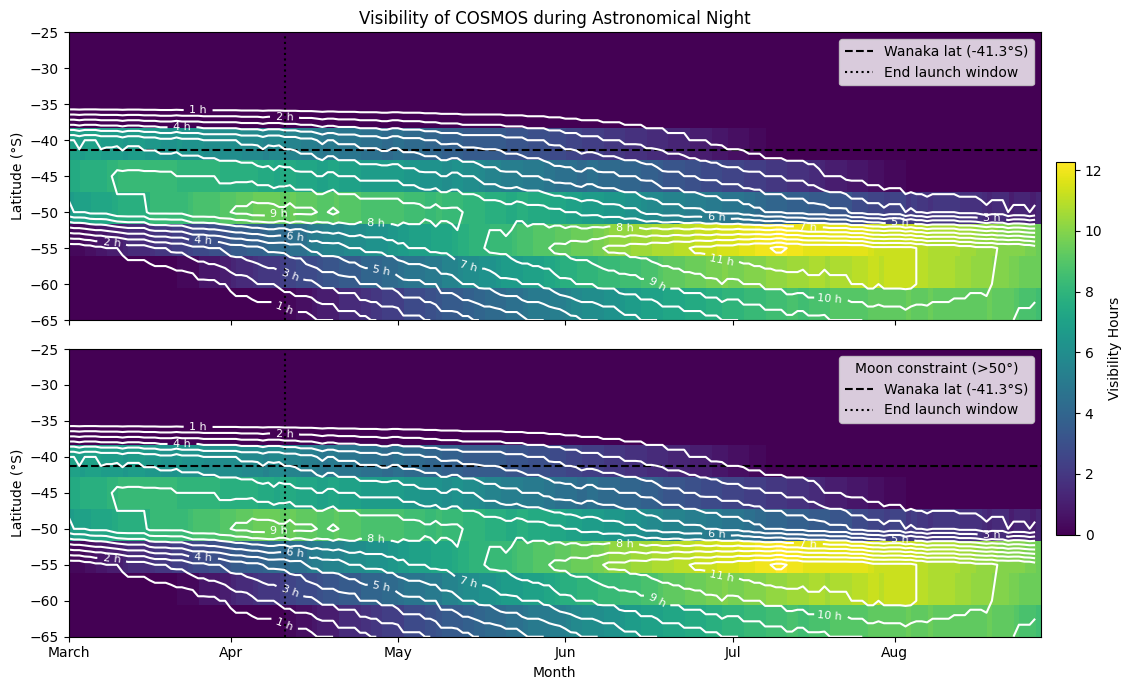

0 <SkyCoord (ICRS): (ra, dec) in deg
    (150., -90.)>
-65
-60
-55
-50
-45
-40
-35
-30
-25
1 <SkyCoord (ICRS): (ra, dec) in deg
    (150., -67.5)>
-65
-60
-55
-50
-45
-40
-35
-30
-25
2 <SkyCoord (ICRS): (ra, dec) in deg
    (150., -45.)>
-65
-60
-55
-50
-45
-40
-35
-30
-25
3 <SkyCoord (ICRS): (ra, dec) in deg
    (150., -22.5)>
-65
-60
-55
-50
-45
-40
-35
-30
-25
4 <SkyCoord (ICRS): (ra, dec) in deg
    (150., 0.)>
-65
-60
-55
-50
-45
-40
-35
-30
-25


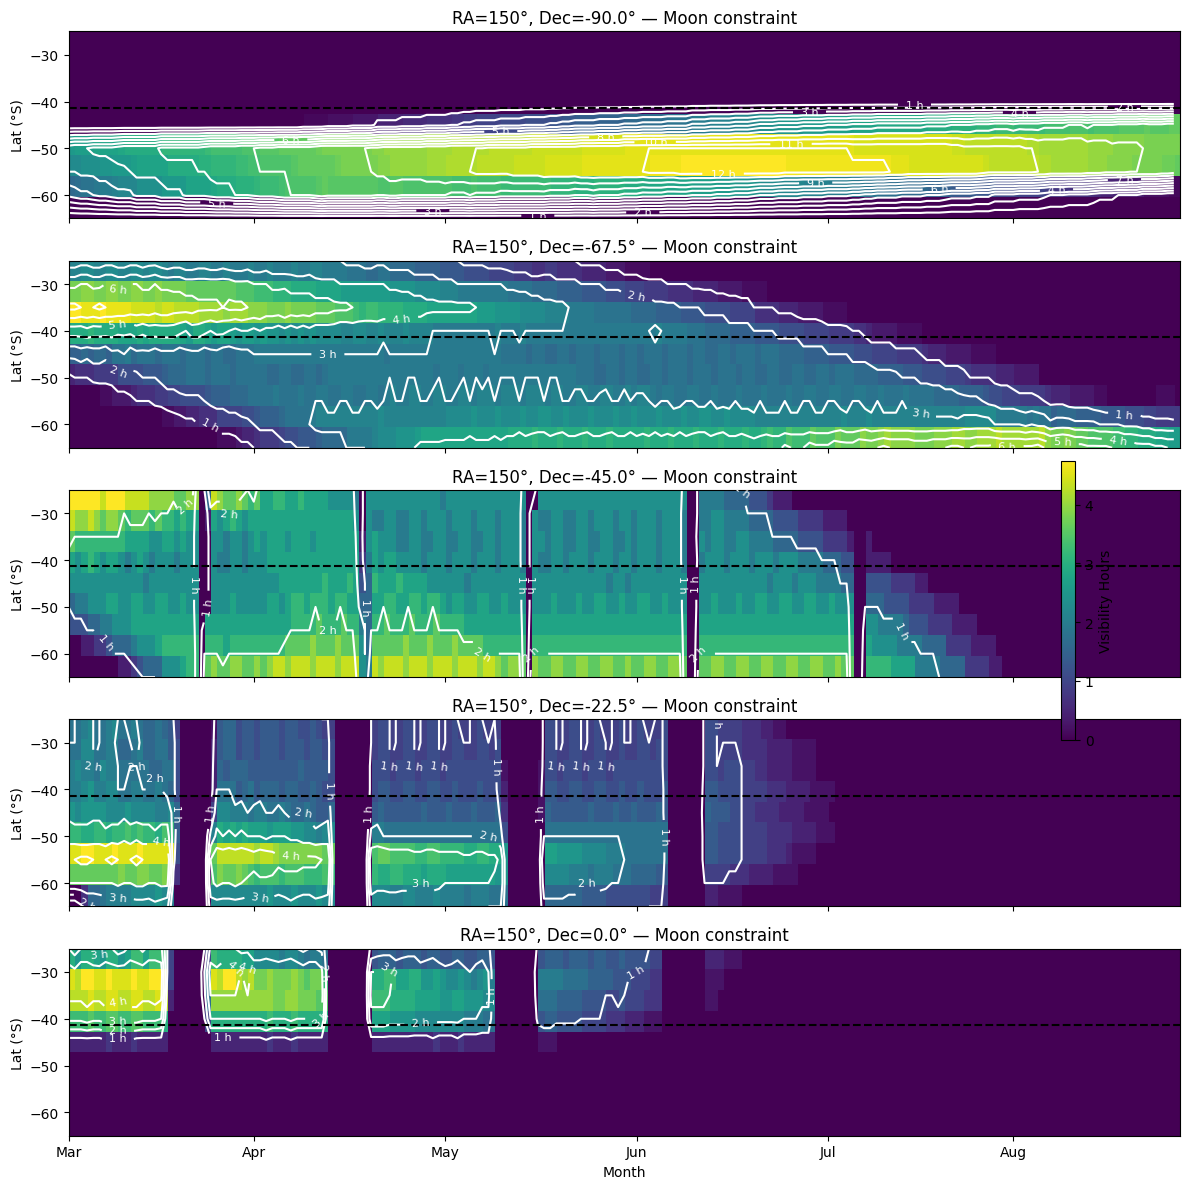

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun, get_body
from astropy.time import Time
import astropy.units as u

limits = [45, 60]

# Paramètres
latitudes = np.arange(-65, -20, 5)
dates = [f"2027-{month:02d}-{day:02d}" for month in range(3, 9) for day in range(1, 31)]

# Cibles de declinaison croissante
target_decs = np.linspace(-90, 0, 5)
targets = [SkyCoord(ra=150 * u.deg, dec=dec * u.deg) for dec in target_decs]

# Préparation du subplot
fig, axs = plt.subplots(len(targets), 1, figsize=(12, 12), sharex=True)

for idx, (target, ax) in enumerate(zip(targets, axs)):
    print(idx, target)
    visibility_matrix_moon = np.zeros((len(latitudes), len(dates)))

    for i, lat in enumerate(latitudes):
        print(lat)
        location = EarthLocation(lat=lat * u.deg, lon=0 * u.deg)
        time_grid = Time([f"{date} 00:00:00" for date in dates])[:, None] + np.linspace(0, 24, 96) * u.hour
        altaz_frame = AltAz(obstime=time_grid, location=location)
        altaz = target.transform_to(altaz_frame)
        sun_altaz = get_sun(time_grid).transform_to(altaz_frame)
        moon_altaz = get_body("moon", time_grid).transform_to(altaz_frame)
        moon_distance = altaz.separation(moon_altaz)

        # Conditions
        is_night = sun_altaz.alt < -18 * u.deg
        is_visible = (altaz.alt >= limits[0] * u.deg) & (altaz.alt <= limits[1] * u.deg)
        is_moon_far = (moon_distance > 50 * u.deg)
        valid = is_night & is_visible & is_moon_far
        visibility_matrix_moon[i, :] = valid.sum(axis=1) * 0.25

    im = ax.imshow(
        visibility_matrix_moon,
        origin='lower',
        aspect='auto',
        extent=[0, len(dates), np.min(latitudes), np.max(latitudes)],
        cmap='viridis'
    )
    X, Y = np.meshgrid(np.arange(len(dates)), latitudes)
    contours = ax.contour(X, Y, visibility_matrix_moon, levels=np.arange(1, 13), colors='white')
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f h')

    ax.axhline(y=-41.3, color='k', linestyle='--', label='Wanaka lat')
    ax.set_ylabel("Lat (°S)")
    ax.set_title(f"RA=150°, Dec={target.dec.value:.1f}° — Moon constraint")
    if idx == len(targets) - 1:
        month_positions = np.array([0, 30, 61, 92, 123, 153, 184])
        month_labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
        ax.set_xticks(month_positions[:-1])
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Month")
    else:
        ax.label_outer()

# Colorbar partagée
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.01)
cbar.set_label("Visibility Hours")

plt.tight_layout()
plt.show()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


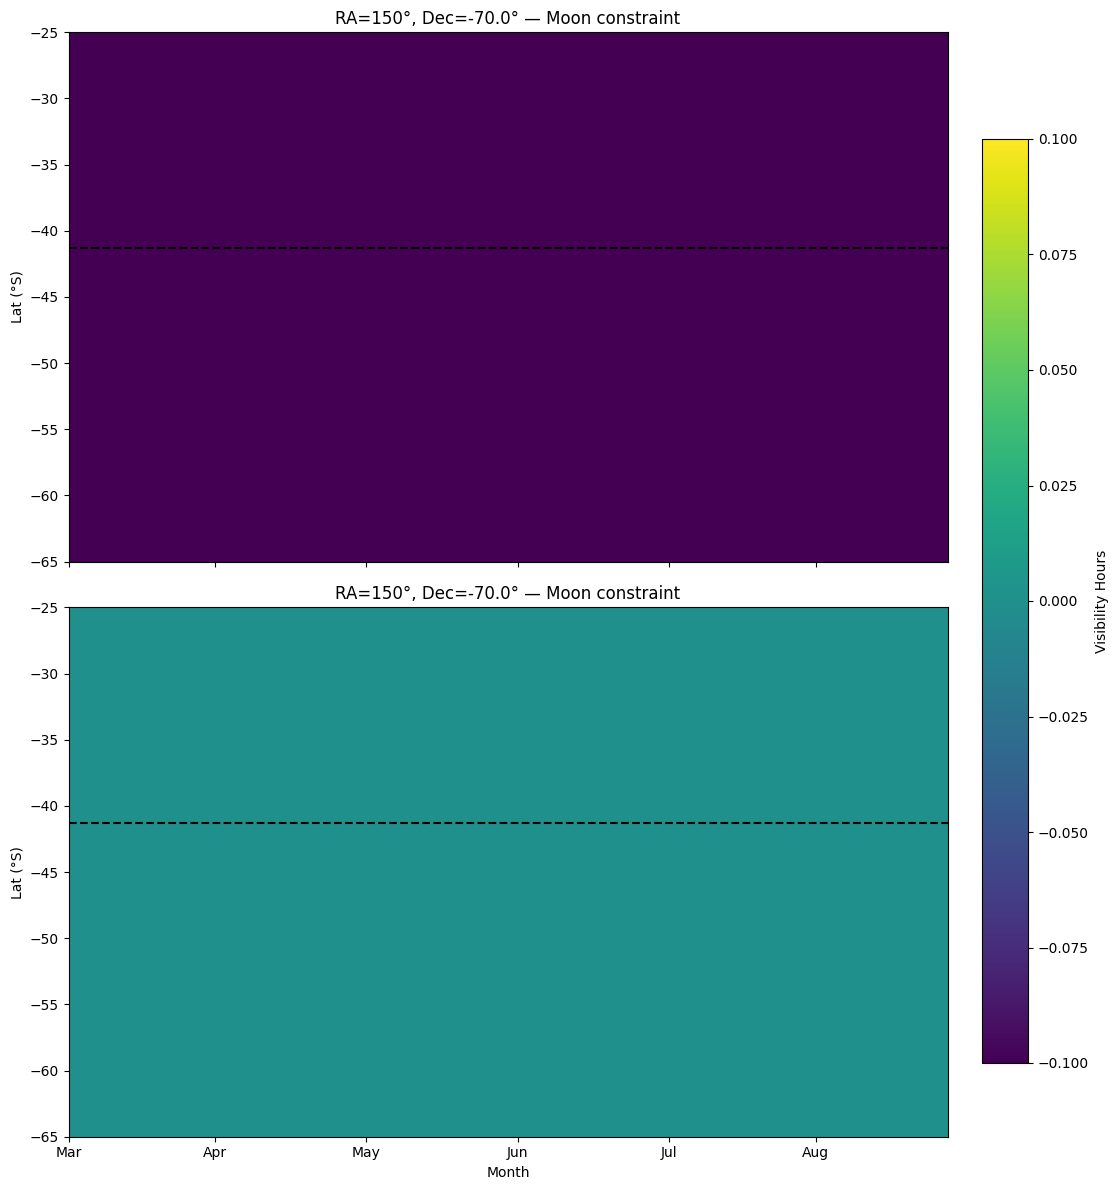

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun, get_body
from astropy.time import Time
import astropy.units as u
%load_ext line_profiler

limits = [45, 60]

# Paramètres
latitudes = np.arange(-65, -20, 5)
dates = [f"2027-{month:02d}-{day:02d}" for month in range(3, 9) for day in range(1, 31)]

# Cibles de declinaison croissante
target_decs = np.linspace(-90, 0, 5)
target_ras = np.linspace(0,360, 2)
targets = [SkyCoord(ra=150 * u.deg, dec=dec * u.deg) for dec in target_decs]
targets = [SkyCoord(ra=ra * u.deg, dec=-70 * u.deg) for ra in target_ras]

# @profile
def compute_visibility_for_latitude(lat, source_coord, dates, limits):
    from astropy.coordinates import AltAz, EarthLocation
    from astropy.time import Time
    import numpy as np
    import astropy.units as u

    location = EarthLocation(lat=lat*u.deg, lon=0*u.deg, height=4000*u.m)
    time_grid = Time([f"2027-{date[5:]} 00:00:00" for date in dates])[:, None] + np.linspace(0, 24, 96) * u.hour
    altaz_frame = AltAz(obstime=time_grid, location=location)
    altaz = source_coord.transform_to(altaz_frame)
    sun_altaz = get_sun(time_grid).transform_to(altaz_frame)
    moon_coord = get_body("moon", time_grid)
    moon_altaz = moon_coord.transform_to(altaz_frame)
    moon_distance = altaz.separation(moon_altaz)

    is_night = sun_altaz.alt < -18 * u.deg
    is_visible = (altaz.alt >= limits[0] * u.deg) & (altaz.alt <= limits[1] * u.deg)
    is_moon_far = moon_distance > 50 * u.deg
    valid = is_night & is_visible & is_moon_far

    return (is_night & is_visible).sum(axis=1) * 0.25, valid.sum(axis=1) * 0.25


# Préparation du subplot
fig, axs = plt.subplots(len(targets), 1, figsize=(12, 12), sharex=True)

for idx, (target, ax) in enumerate(zip(targets, axs)):
    # print(idx, target)
    visibility_matrix_moon = np.zeros((len(latitudes), len(dates)))

    for i, lat in enumerate(latitudes):
        # vis, vis_moon = 0,0#compute_visibility_for_latitude(lat, source_coord, dates, limits)
        vis, vis_moon = compute_visibility_for_latitude(lat, source_coord, dates, limits)

    im = ax.imshow(
        visibility_matrix_moon,
        origin='lower',
        aspect='auto',
        extent=[0, len(dates), np.min(latitudes), np.max(latitudes)],
        cmap='viridis'
    )
    X, Y = np.meshgrid(np.arange(len(dates)), latitudes)
    contours = ax.contour(X, Y, visibility_matrix_moon, levels=np.arange(1, 13), colors='white')
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f h')

    ax.axhline(y=-41.3, color='k', linestyle='--', label='Wanaka lat')
    ax.set_ylabel("Lat (°S)")
    ax.set_title(f"RA=150°, Dec={target.dec.value:.1f}° — Moon constraint")
    if idx == len(targets) - 1:
        month_positions = np.array([0, 30, 61, 92, 123, 153, 184])
        month_labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
        ax.set_xticks(month_positions[:-1])
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Month")
    else:
        ax.label_outer()

# Colorbar partagée
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.1, pad=-0.35)
cbar.set_label("Visibility Hours")

plt.tight_layout()
plt.show()

NameError: name 'lines' is not defined

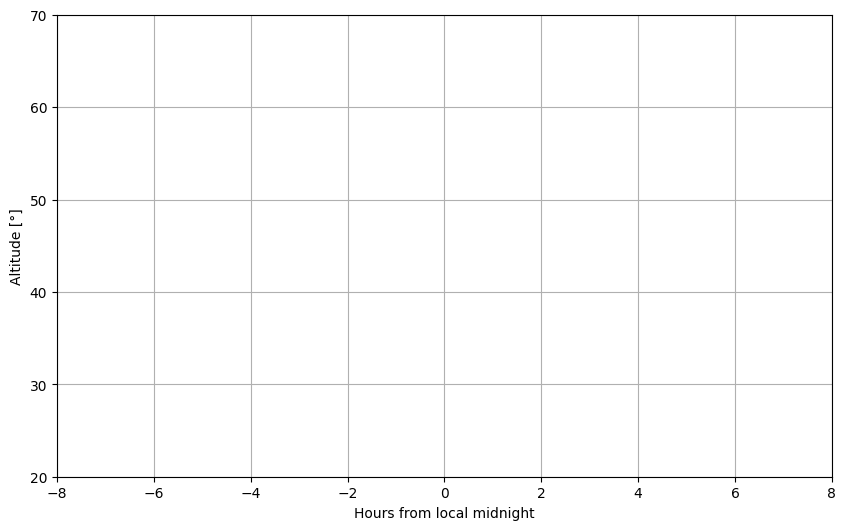

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, get_sun, get_body
from astropy.time import Time
from astropy.visualization import quantity_support
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from datetime import datetime
import warnings
from astral import moon
warnings.filterwarnings("ignore")
quantity_support()
year = 2026
wanaka_long = 169.2455
# wanaka_long = 19.2455


# Initialisation globale
# fig, ax = plt.subplots(figsize=(10, 6))
# lines = {}         # {label: Line2D}
# scatters = {}      # {label: PathCollection}
# texts = []         # list of Text
# sun_line = None
# moon_line = None
# title_text = None
# colorbar = None


def init_plot():
    global fig, ax, lines, scatters, texts, sun_line, moon_line, title_text, colorbar

    fig, ax = plt.subplots(figsize=(10, 6))

    # Placeholders vides au début
    sun_line, = ax.plot([np.nan], [np.nan], 'r', label='Soleil')
    moon_line, = ax.plot([np.nan], [np.nan], '--', color='gray', label='Lune')

    title_text = ax.set_title("")
    ax.set_xlabel("Hours from local midnight")
    ax.set_ylabel("Altitude [°]")
    ax.set_xlim(-8, 8)
    ax.set_ylim(20, 70)
    ax.grid(True)

    colorbar = None  # Initialisé lors du premier scatter

    # Placeholders pour targets (remplis au premier update)
    for label in target_box.options:
        target_name = label.split(":")[0]
        line, = ax.plot([], [], 'o', label=target_name)
        lines[target_name] = line
        scatters[target_name] = ax.scatter([], [], c=[], cmap='viridis', s=8)

    ax.legend(loc="upper left")
    return fig

def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : `~astropy.units.Quantity`
        Phase angle of the moon [radians]
    """
    sun = get_sun(time)
    moon = get_body("moon", time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance * np.sin(elongation),
                      moon.distance - sun.distance * np.cos(elongation))

def get_moons_in_year(year: int) :
  """Returns a list of the full and new moons in a year. The list contains tuples
of either the form (DATE,'full') or the form (DATE,'new')"""
  moons=[]
  date=ephem.Date(datetime.date(year,1,1))
  while date.datetime().year==year:
    date=ephem.next_full_moon(date)
    moons.append( (date,'full') )
  date=ephem.Date(datetime.date(year,1,1))
  while date.datetime().year==year:
    date=ephem.next_new_moon(date)
    moons.append( (date,'new') )
  #Note that previous_first_quarter_moon() and previous_last_quarter_moon()
  #are also methods
  moons.sort(key=lambda x: x[0])

  return moons

# Widgets : sliders latitude, longitude
lat_slider = widgets.FloatSlider(
    value=-41.3,
    min=-65.0,
    max=-20.0,
    step=0.1,
    description='Latitude [°S]',
    continuous_update=True
)

lon_slider = widgets.FloatSlider(
    value=wanaka_long,
    min=-180.0,
    max=180.0,
    step=1.0,
    description='Longitude [°]',
    continuous_update=True
)



# Widget cible céleste (Combobox RA/DEC)
target_box = widgets.SelectMultiple(
    options=[
        "COSMOS: α=150, δ=2",
        "DEEP2-3: α=352, δ=0",
        "ELAIS N1: α=243, δ=55",
        "XMM-LSS: α=36, δ=2-5",
        "Optimized: α=150, δ=-80",
        "Crab Nebula:α=83.63, δ=22.01", 
        "Test: α=210, δ=-60"
    ],
    value=["COSMOS: α=150, δ=2"],
    description='Targets :',
    layout={'width': '400px', 'height': '100px'}
)

def parse_coordinates(text):
    try:
        # Extraction des valeurs numériques depuis la chaîne de type "COSMOS: α=150, δ=2"
        import re
        matches = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', text)
        if len(matches) >= 2:
            ra = float(matches[0])
            dec = float(matches[1])
            return SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    except Exception as e:
        print("Erreur dans le parsing :", e)
    # Valeur par défaut si parsing échoue
    return SkyCoord(ra=150 * u.deg, dec=2 * u.deg, frame='icrs')



# Nouveaux widgets
launch_start = datetime(year, 3, 20)
launch_end = datetime(year, 5, 31)
launch_dates = pd.date_range(launch_start, launch_end, freq='D')
launch_options = [(d.strftime('%d %b %Y'), d) for d in launch_dates]
launch_date_slider = widgets.SelectionSlider(
    options=launch_options,
    index=0,
    description='Launch :',
    layout={'width': '700px'}
)

day_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=50,
    step=1,
    description='Day [+]',
    continuous_update=True
)

fix_longitude_box = widgets.Checkbox(
    value=True,
    description="Follow East drift (~24°/day)"
)

def sync_longitude_slider(*args):
    """Update longitude slider based on checkbox and day slider (modulo 360 to stay in [-180, 180])"""
    if fix_longitude_box.value:
        lon_slider.disabled = True
        lon = wanaka_long + 24.0 * day_slider.value  # eastward drift: ~1 turn in 15 days
        # Wrap longitude to [-180, 180]
        lon = ((lon + 180) % 360) - 180
        lon_slider.value = lon
    else:
        lon_slider.disabled = False

fix_longitude_box.observe(sync_longitude_slider, 'value')
day_slider.observe(sync_longitude_slider, 'value')
sync_longitude_slider()


# Fonction mise à jour avec dérive
def update_plot_content(lat_s, lon_manual, launch_date, day_offset, target_texts, fix_longitude):
    global fig, ax, lines, scatters, texts, sun_line, moon_line, title_text, colorbar

    # Reset annotations
    for t in texts:
        t.remove()
    texts.clear()

    lat = lat_s
    lon = wanaka_long + 24.0 * day_offset if fix_longitude else lon_manual
    date = launch_date + pd.to_timedelta(day_offset, unit='D')
    location = EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=390 * u.m)

    utcoffset = (lon / 15.0) * u.hour
    midnight_local = Time(datetime(date.year, date.month, date.day, 0, 0)) - utcoffset
    delta_midnight = np.linspace(-12, 12, 1000) * u.hour
    times = midnight_local + delta_midnight
    frame = AltAz(obstime=times, location=location)

    sun_altaz = get_sun(times).transform_to(frame)
    moon_altaz = get_body("moon", times).transform_to(frame)

    # MAJ Soleil / Lune
    sun_line.set_data(delta_midnight.value, sun_altaz.alt.value)
    moon_line.set_data(delta_midnight.value, moon_altaz.alt.value)

    moon_phase = (180 - moon_phase_angle(Time(datetime(date.year, date.month, date.day, 0, 0))).to(u.deg).value) / 1.8
    moon_line.set_label(f"Lune (Phase: {moon_phase:.1f}%)")

    hourly_indices = np.arange(0, len(times), len(times)//24)
    moon_coord = get_body("moon", times[hourly_indices])

    for full_label in target_box.options:
        target_name = full_label.split(":")[0]

        if full_label in target_texts:
            coord = parse_coordinates(full_label)
            altaz = coord.transform_to(frame)

            # MAJ courbe
            lines[target_name].set_data(delta_midnight.value, altaz.alt.value)
            scatters[target_name].set_offsets(np.column_stack([delta_midnight.value, altaz.alt.value]))
            scatters[target_name].set_array(altaz.az.value)
        else:
            # Masquer la cible non sélectionnée
            lines[target_name].set_data([], [])
            scatters[target_name].set_offsets(np.empty((0, 2)))
            scatters[target_name].set_array(np.array([]))

            # for i, idx in enumerate(hourly_indices):
            #     if (25 < altaz.alt[idx].value < 70) and (-6 < delta_midnight[idx].value < 6):
            #         text = ax.text(delta_midnight[idx].value, altaz.alt[idx].value + 2,
            #                        f"{sep_moon[i].to(u.deg).value:.0f}°", fontsize=7,
            #                        ha='center', color='white')
            #         texts.append(text)

        # else:
        #     # MASQUER avec NaN
        #     lines[name].set_data([], [])
        #     scatters[name].set_offsets(np.empty((0, 2)))
        #     scatters[name].set_array(np.array([]))

    title_text.set_text(f"Day {day_offset}: {date.strftime('%d %b %Y')} from {lat:.1f}°, {lon:.1f}°")
    ax.legend(loc="upper left")
    fig.canvas.draw_idle()



fig = init_plot()

# Interface interactive complète
ui = widgets.VBox([
    launch_date_slider,
    day_slider,
    fix_longitude_box,
    lat_slider,
    lon_slider,
    target_box
])
out = widgets.interactive_output(update_plot_content, {
    'lat_s': lat_slider,
    'lon_manual': lon_slider,
    'launch_date': launch_date_slider,
    'day_offset': day_slider,
    'target_texts': target_box,
    'fix_longitude': fix_longitude_box
})

display(ui, out)

#TODO ajouter la distance de COSMOS à la lune une heure apres le coucher du soleil
# ajouter la distance au soleil en azimuth au moment du coucher du soleil
# ajouter un plot à droite de la trajectoire
# Remplace le combobox par une liste que l’on peut cocher avec aussi soleil et lune.